In [ ]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.7/364.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip show flwr

Name: flwr
Version: 1.9.0
Summary: Flower: A Friendly Federated Learning Framework
Home-page: https://flower.ai
Author: The Flower Authors
Author-email: hello@flower.ai
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: cryptography, grpcio, iterators, numpy, pathspec, protobuf, pycryptodome, tomli, typer
Required-by: 


In [109]:
from os.path  import join
from collections import OrderedDict
import struct
from array import array
import numpy as np
from typing import List, Tuple, Dict, Any
import pandas as pd
import math
import random


# mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

import flwr as fl
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training on cpu using PyTorch 2.3.0+cu121 and Flower 1.9.0


## MNIST Data

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.int64)

class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        X_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        X_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (X_train, y_train), (X_test, y_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
input_path = '/content/drive/MyDrive/Colab Notebooks/flower-mnist/data'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

training_images_filepath

'/content/drive/MyDrive/Colab Notebooks/flower-mnist/data/train-images-idx3-ubyte/train-images-idx3-ubyte'

In [ ]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()

X_train, X_test = np.expand_dims(np.array(X_train), axis=1), np.expand_dims(np.array(X_test), axis=1)
y_train, y_test = np.array(y_train), np.array(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 1, 28, 28), (60000,), (10000, 1, 28, 28), (10000,))

## Load Data

In [ ]:
BATCH_SIZE = 32

class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X_data[idx], dtype=torch.float32)
        y = torch.tensor(self.y_data[idx], dtype=torch.long)
        return x, y

# Splits a dataset into subsets for multiple clients.
def split_dataset(dataset, num_clients):
    subset_size = len(dataset) // num_clients
    subset_sizes = []
    for i in range(num_clients):
        if i + 1 == num_clients:
            subset_sizes.append(len(dataset) - i * subset_size)
        else:
            subset_sizes.append(subset_size)
    return subset_sizes

def load_data(num_clients):
    train_set = CustomDataset(X_train, y_train)
    test_set = CustomDataset(X_test, y_test)

    # Divide the data set randomly
    client_train_sets = random_split(train_set, split_dataset(train_set, num_clients))
    client_test_sets = random_split(test_set, split_dataset(test_set, num_clients))

    train_loaders = []
    test_loaders = []

    for i in range(num_clients):
        train_subset, test_subset = client_train_sets[i], client_test_sets[i]

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

        train_loaders.append(train_loader)
        test_loaders.append(test_loader)

    num_examples = {"trainset" : len(train_set), "testset" : len(test_set)}

    return train_loaders, test_loaders, num_examples

## CNN

In [ ]:
def train(net, trainloader, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for _ in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()

def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return loss, accuracy

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)        # 1 input channel (grayscale), 10 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(10, 32, 5)       # 10 input channels, 32 output channels, 5x5 kernel
        self.conv3 = nn.Conv2d(32, 64, 3)       # 32 input channels, 64 output channels, 3x3 kernel
        self.pool  = nn.MaxPool2d(2, 2)         # 2x2 pooling layer
        self.fc1   = nn.Linear(256, 128)        # Dense layer
        self.fc2   = nn.Linear(128, 64)         # Dense layer
        self.fc3   = nn.Linear(64, 10)          # 64 inputs, 10 outputs for the 10 classes
        # Steps:
            # Conv1: 28x28 -> 24x24 (28 - 5 + 1)
            # Pool:  24x24 -> 12x12 (24 / 2)
            # Conv2: 12x12 -> 8x8   (12 - 5 + 1)
            # Pool:  8x8   -> 4x4   (8 / 2)
            # Conv3: 4x4   -> 2x2   (4 - 3 + 1)
            # Flatn: 2x2   -> 1x256 (2 * 2 * 64)
            # Dense: 1x256 -> 1x128
            # Dense: 1x128 -> 1x64
            # Dense: 1x64  -> 1x10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # (12, 12, 10)
        x = self.pool(F.relu(self.conv2(x))) # (4, 4, 32)
        x = F.relu(self.conv3(x))            # (2, 2, 64)
        x = x.view(-1, 256)                  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class MethodBClient(fl.client.NumPyClient):
    def __init__(self, cid, net, train_loader, test_loader):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.net = net
        self.cid = cid

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(self.net, self.train_loader, epochs=1)
        _, accuracy = test(self.net, self.test_loader)
        # print(f"No. {self.cid} client is fitted")
        return self.get_parameters(config={}), num_examples["trainset"], {"accuracy": accuracy}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(self.net, self.test_loader)
        # print(f"No. {self.cid} client is evaluated")
        return float(loss), num_examples["testset"], {"accuracy": float(accuracy)}


In [122]:

class CustomFedMedian(fl.server.strategy.FedMedian):
    def __init__(self, p, num_clients, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p  # Fraction of clients to select
        self.num_clients = num_clients
        self.accuracies = []
        self.losses = []
        self.accuracy_df = pd.DataFrame()

        self.selected_clients = []  # To store selected clients
        self.accuracies = [None] * num_clients  # Store accuracies for each client
        self.probability_df = pd.DataFrame()

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:

        sample_size = int(self.p * self.num_clients)
        all_clients = client_manager.all()
        selected_clients_cids = [client.cid for client in self.selected_clients]

        # print(all_clients)

        if(server_round == 1):
            # Round 1: All nodes have p probability of selection
            selected_clients = client_manager.sample(num_clients=sample_size, min_num_clients=sample_size)

            # store round probabilities
            round_probabilities = {f"Client {cid + 1}": self.p for cid in range(self.num_clients)}

        else:
            # Round t: Nodes have selection probability based on accuracy from previous round
            selected_clients = []
            round_probabilities = {}

            for client_cid in range(self.num_clients):
                client_key = f"Client {client_cid + 1}"

                if str(client_cid) in selected_clients_cids:
                    last_round_accuracy = self.accuracy_df[client_key].iloc[-1]
                    prob = max(np.exp(-1.5 * last_round_accuracy), 0.1)
                else:
                    prob = self.p

                # store round probabilities
                round_probabilities[client_key] = prob

                if np.random.rand() < prob:
                    selected_clients.append(all_clients[str(client_cid)])

        # Ensure at least one client is selected
        if not selected_clients:
            selected_clients.append(all_clients[str(random.randint(0, self.num_clients) - 1)])
        print(f"random client: {all_clients[str(random.randint(0, self.num_clients) - 1)]}")

        # update selected clients
        self.selected_clients = selected_clients

        # Update probability dataframe
        prob_df = pd.DataFrame(round_probabilities, index=[server_round])
        self.probability_df = pd.concat([self.probability_df, prob_df])

        fit_ins = FitIns(parameters, {})

        print(f"Serial number of the client selected to fit: {[client.cid for client in self.selected_clients]}")
        return [(client, fit_ins) for client in self.selected_clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:

        # Use only selected clients for evaluation
        evaluate_clients = self.selected_clients

        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Return client/config pairs for evaluation
        print(f"Serial number of the client selected to evaluate: {[client.cid for client in evaluate_clients]}")
        return [(client, evaluate_ins) for client in evaluate_clients]

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Initialize dictionaries to store evaluated client accuracy
        evaluated_client_dict = {}
        round_accuracy_dict = {}

        for client_proxy, evaluate_res in results:
            # Assume evaluate_res has an 'accuracy' attribute
            client_cid = int(client_proxy.cid)
            accuracy = evaluate_res.metrics["accuracy"]

            evaluated_client_dict[client_cid] = accuracy
            # print(f"cid: {client_cid}, accuracy: {accuracy}")

        # Generate accuracy dict for all clients
        for client_cid in range(self.num_clients):
            client_key = f"Client {client_cid + 1}"
            if client_cid in evaluated_client_dict.keys():
                round_accuracy_dict[client_key] = evaluated_client_dict[client_cid]
            else:
                if(rnd == 1):
                    round_accuracy_dict[client_key] = float('NaN')
                else:
                    round_accuracy_dict[client_key] = self.accuracy_df[client_key].iloc[-1]

        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        # round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}

        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)

        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])

        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def plot_loss_per_client_per_round(self):
        num_rounds = len(self.losses)
        num_clients = len(self.losses[0])

        plt.figure()
        for client_idx in range(num_clients):
            plt.plot(range(1, num_rounds + 1), [self.losses[r][client_idx] for r in range(num_rounds)], marker='o', label=f'Client {client_idx + 1}')

        plt.title("Loss per Client per Round")
        plt.xlabel("Round")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        """打印所有轮次和客户端的分类准确率矩阵"""
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)

In [123]:
def client_fn(cid: str) -> MethodBClient:
    train_loader = train_loaders[int(cid)]
    test_loader = test_loaders[int(cid)]
    net = Net().to(DEVICE)

    # print(f"cid: {int(cid)}")

    return MethodBClient(cid, net, train_loader, test_loader).to_client()

## Start Simulation

### clients = 40, round = 50, p = 0.25

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-09 00:54:52,150	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3987889766.0, 'memory': 7975779534.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial paramet

random client: <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7a26716e4370>
Serial number of the client selected to fit: ['3', '1']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Serial number of the client selected to evaluate: ['3', '1']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 4)


random client: <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7a26716e43d0>
Serial number of the client selected to fit: ['0', '2']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Serial number of the client selected to evaluate: ['0', '2']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 1 clients (out of 4)


random client: <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7a26716e43a0>
Serial number of the client selected to fit: ['0']


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 4)


Serial number of the client selected to evaluate: ['0']


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 4)


random client: <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7a26716e43a0>
Serial number of the client selected to fit: ['1', '3']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Serial number of the client selected to evaluate: ['1', '3']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 4)


random client: <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7a26716e4490>
Serial number of the client selected to fit: ['0', '3']


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Serial number of the client selected to evaluate: ['0', '3']


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 58.51s
INFO :      	History (loss, distributed):
INFO :      		round 1: 18.129462351091206
INFO :      		round 2: 6.175052787075401
INFO :      		round 3: 7.5347569629666395
INFO :      		round 4: 4.278840383514762
INFO :      		round 5: 4.294960783576244
INFO :      


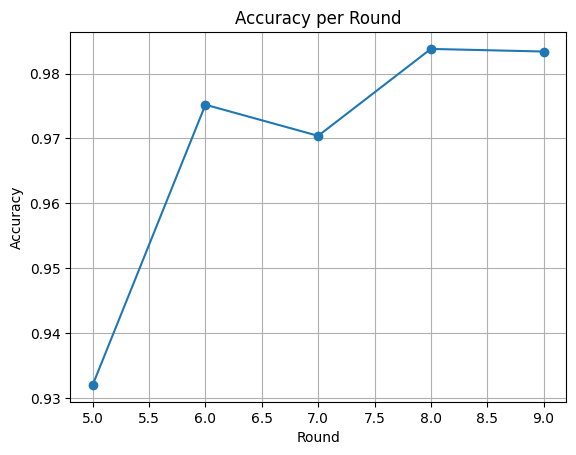

Classification Accuracy Matrix:
   Client 1  Client 2  Client 3  Client 4
1       NaN    0.9296       NaN    0.9344
2    0.9736    0.9296    0.9768    0.9344
3    0.9704    0.9296    0.9768    0.9344
4    0.9704    0.9828    0.9768    0.9848
5    0.9824    0.9828    0.9768    0.9844


In [124]:
# Load model and data
NUM_CLIENTS = 4
ROUND = 5
p = 0.5

train_loaders, test_loaders, num_examples = load_data(NUM_CLIENTS)
strategy = CustomFedMedian(p, NUM_CLIENTS)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=ROUND),
    strategy=strategy
)

strategy.plot_accuracies()
# strategy.plot_loss_per_client_per_round()
strategy.print_accuracy_matrix()



In [ ]:
strategy.probability_df

In [118]:
random.randint(-1, 1)

0

### clients = 40, round = 50, p = 0.5

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-25 21:00:16,551	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3994086604.0, 'memory': 7988173211.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parame

Serial number of the client selected to fit: ['19', '27', '37', '2', '30', '8', '11', '23', '15', '5', '34', '32', '39', '1', '33', '0', '21', '17', '36', '29']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['19', '27', '37', '2', '30', '8', '11', '23', '15', '5', '34', '32', '39', '1', '33', '0', '21', '17', '36', '29']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['20', '11', '33', '27', '32', '7', '26', '19', '15', '30', '34', '28', '35', '1', '8', '17', '21', '3', '25', '12']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['20', '11', '33', '27', '32', '7', '26', '19', '15', '30', '34', '28', '35', '1', '8', '17', '21', '3', '25', '12']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['38', '11', '18', '14', '6', '23', '3', '27', '16', '21', '8', '10', '30', '39', '7', '36', '34', '32', '9', '17']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['38', '11', '18', '14', '6', '23', '3', '27', '16', '21', '8', '10', '30', '39', '7', '36', '34', '32', '9', '17']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['15', '35', '16', '24', '20', '31', '2', '11', '28', '37', '4', '36', '8', '38', '33', '34', '1', '10', '5', '25']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['15', '35', '16', '24', '20', '31', '2', '11', '28', '37', '4', '36', '8', '38', '33', '34', '1', '10', '5', '25']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['4', '12', '25', '36', '9', '19', '5', '24', '29', '34', '35', '0', '8', '33', '31', '16', '2', '32', '3', '11']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['4', '12', '25', '36', '9', '19', '5', '24', '29', '34', '35', '0', '8', '33', '31', '16', '2', '32', '3', '11']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['1', '2', '35', '22', '13', '30', '24', '39', '29', '33', '17', '37', '3', '0', '7', '15', '9', '6', '32', '8']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['1', '2', '35', '22', '13', '30', '24', '39', '29', '33', '17', '37', '3', '0', '7', '15', '9', '6', '32', '8']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['0', '13', '5', '24', '30', '28', '8', '18', '19', '15', '14', '3', '37', '20', '33', '22', '11', '38', '31', '27']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['0', '13', '5', '24', '30', '28', '8', '18', '19', '15', '14', '3', '37', '20', '33', '22', '11', '38', '31', '27']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['14', '23', '39', '2', '24', '21', '31', '4', '22', '27', '8', '18', '10', '37', '36', '19', '11', '16', '5', '33']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['14', '23', '39', '2', '24', '21', '31', '4', '22', '27', '8', '18', '10', '37', '36', '19', '11', '16', '5', '33']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['27', '12', '22', '39', '1', '2', '16', '24', '4', '6', '33', '15', '20', '11', '32', '35', '29', '30', '26', '13']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['27', '12', '22', '39', '1', '2', '16', '24', '4', '6', '33', '15', '20', '11', '32', '35', '29', '30', '26', '13']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['11', '13', '8', '17', '3', '2', '23', '4', '21', '37', '28', '20', '29', '18', '35', '25', '19', '14', '6', '32']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['11', '13', '8', '17', '3', '2', '23', '4', '21', '37', '28', '20', '29', '18', '35', '25', '19', '14', '6', '32']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['9', '28', '17', '15', '16', '7', '31', '12', '18', '36', '39', '11', '30', '10', '23', '35', '29', '33', '22', '1']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['9', '28', '17', '15', '16', '7', '31', '12', '18', '36', '39', '11', '30', '10', '23', '35', '29', '33', '22', '1']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['0', '17', '4', '8', '11', '19', '9', '26', '27', '1', '2', '12', '38', '16', '22', '29', '39', '14', '23', '15']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['0', '17', '4', '8', '11', '19', '9', '26', '27', '1', '2', '12', '38', '16', '22', '29', '39', '14', '23', '15']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['9', '22', '39', '14', '32', '27', '35', '38', '13', '18', '0', '1', '16', '34', '30', '28', '15', '24', '29', '5']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['9', '22', '39', '14', '32', '27', '35', '38', '13', '18', '0', '1', '16', '34', '30', '28', '15', '24', '29', '5']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['31', '18', '32', '24', '28', '33', '15', '9', '16', '14', '19', '29', '27', '2', '11', '10', '4', '23', '6', '3']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['31', '18', '32', '24', '28', '33', '15', '9', '16', '14', '19', '29', '27', '2', '11', '10', '4', '23', '6', '3']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['35', '30', '15', '18', '2', '12', '17', '6', '16', '4', '21', '8', '26', '31', '10', '24', '28', '7', '20', '9']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['35', '30', '15', '18', '2', '12', '17', '6', '16', '4', '21', '8', '26', '31', '10', '24', '28', '7', '20', '9']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['9', '20', '5', '14', '12', '3', '26', '21', '22', '29', '32', '34', '24', '30', '7', '27', '2', '0', '16', '38']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['9', '20', '5', '14', '12', '3', '26', '21', '22', '29', '32', '34', '24', '30', '7', '27', '2', '0', '16', '38']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['5', '21', '12', '17', '15', '8', '6', '0', '11', '39', '4', '1', '16', '3', '38', '36', '14', '2', '34', '24']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['5', '21', '12', '17', '15', '8', '6', '0', '11', '39', '4', '1', '16', '3', '38', '36', '14', '2', '34', '24']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['30', '17', '38', '20', '27', '26', '3', '10', '21', '15', '4', '28', '37', '32', '14', '11', '8', '1', '33', '29']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['30', '17', '38', '20', '27', '26', '3', '10', '21', '15', '4', '28', '37', '32', '14', '11', '8', '1', '33', '29']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['39', '19', '10', '4', '6', '33', '1', '23', '22', '7', '28', '17', '18', '5', '29', '2', '34', '13', '3', '21']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['39', '19', '10', '4', '6', '33', '1', '23', '22', '7', '28', '17', '18', '5', '29', '2', '34', '13', '3', '21']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['33', '5', '23', '30', '9', '4', '14', '8', '11', '35', '37', '3', '28', '36', '15', '1', '13', '32', '31', '18']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['33', '5', '23', '30', '9', '4', '14', '8', '11', '35', '37', '3', '28', '36', '15', '1', '13', '32', '31', '18']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['39', '23', '14', '29', '31', '17', '34', '8', '26', '19', '6', '10', '1', '38', '7', '30', '0', '25', '3', '13']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['39', '23', '14', '29', '31', '17', '34', '8', '26', '19', '6', '10', '1', '38', '7', '30', '0', '25', '3', '13']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['37', '5', '19', '29', '3', '16', '15', '6', '38', '20', '10', '31', '23', '8', '12', '30', '28', '39', '26', '35']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['37', '5', '19', '29', '3', '16', '15', '6', '38', '20', '10', '31', '23', '8', '12', '30', '28', '39', '26', '35']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['11', '36', '15', '32', '7', '14', '37', '1', '38', '28', '4', '29', '21', '30', '24', '8', '5', '35', '26', '19']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['11', '36', '15', '32', '7', '14', '37', '1', '38', '28', '4', '29', '21', '30', '24', '8', '5', '35', '26', '19']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['3', '12', '18', '24', '38', '0', '22', '28', '9', '1', '36', '39', '17', '27', '13', '5', '25', '23', '35', '6']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['3', '12', '18', '24', '38', '0', '22', '28', '9', '1', '36', '39', '17', '27', '13', '5', '25', '23', '35', '6']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['6', '9', '28', '1', '25', '33', '12', '23', '34', '8', '39', '26', '10', '13', '32', '27', '19', '4', '22', '15']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['6', '9', '28', '1', '25', '33', '12', '23', '34', '8', '39', '26', '10', '13', '32', '27', '19', '4', '22', '15']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['28', '8', '25', '0', '4', '37', '21', '36', '19', '14', '35', '1', '31', '6', '29', '13', '9', '32', '23', '3']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['28', '8', '25', '0', '4', '37', '21', '36', '19', '14', '35', '1', '31', '6', '29', '13', '9', '32', '23', '3']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['11', '6', '3', '15', '22', '18', '39', '32', '33', '37', '2', '29', '10', '28', '31', '1', '14', '9', '4', '17']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['11', '6', '3', '15', '22', '18', '39', '32', '33', '37', '2', '29', '10', '28', '31', '1', '14', '9', '4', '17']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['24', '14', '12', '25', '16', '36', '15', '18', '37', '5', '0', '26', '31', '21', '3', '11', '34', '30', '27', '29']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['24', '14', '12', '25', '16', '36', '15', '18', '37', '5', '0', '26', '31', '21', '3', '11', '34', '30', '27', '29']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['38', '16', '25', '4', '9', '17', '37', '0', '5', '39', '3', '33', '6', '31', '27', '11', '22', '32', '8', '15']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['38', '16', '25', '4', '9', '17', '37', '0', '5', '39', '3', '33', '6', '31', '27', '11', '22', '32', '8', '15']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['10', '35', '39', '31', '33', '11', '3', '29', '1', '16', '21', '18', '23', '28', '26', '14', '15', '6', '20', '34']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['10', '35', '39', '31', '33', '11', '3', '29', '1', '16', '21', '18', '23', '28', '26', '14', '15', '6', '20', '34']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['37', '23', '27', '21', '16', '29', '3', '7', '6', '35', '9', '34', '32', '17', '0', '15', '28', '39', '36', '31']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['37', '23', '27', '21', '16', '29', '3', '7', '6', '35', '9', '34', '32', '17', '0', '15', '28', '39', '36', '31']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['5', '6', '37', '33', '36', '3', '22', '28', '17', '12', '13', '29', '23', '14', '11', '32', '4', '21', '39', '25']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['5', '6', '37', '33', '36', '3', '22', '28', '17', '12', '13', '29', '23', '14', '11', '32', '4', '21', '39', '25']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['30', '26', '25', '19', '38', '35', '31', '16', '22', '15', '3', '34', '12', '29', '5', '1', '11', '7', '24', '37']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['30', '26', '25', '19', '38', '35', '31', '16', '22', '15', '3', '34', '12', '29', '5', '1', '11', '7', '24', '37']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['19', '2', '9', '34', '12', '15', '22', '6', '37', '23', '7', '13', '21', '24', '32', '10', '17', '1', '26', '27']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['19', '2', '9', '34', '12', '15', '22', '6', '37', '23', '7', '13', '21', '24', '32', '10', '17', '1', '26', '27']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['6', '7', '31', '38', '11', '10', '13', '28', '0', '9', '39', '37', '26', '35', '1', '18', '33', '25', '21', '30']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['6', '7', '31', '38', '11', '10', '13', '28', '0', '9', '39', '37', '26', '35', '1', '18', '33', '25', '21', '30']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['25', '20', '18', '31', '13', '11', '22', '26', '29', '23', '39', '0', '3', '19', '36', '9', '1', '12', '21', '38']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['25', '20', '18', '31', '13', '11', '22', '26', '29', '23', '39', '0', '3', '19', '36', '9', '1', '12', '21', '38']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['29', '36', '17', '15', '24', '38', '35', '4', '7', '22', '39', '33', '5', '1', '18', '21', '19', '14', '10', '3']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['29', '36', '17', '15', '24', '38', '35', '4', '7', '22', '39', '33', '5', '1', '18', '21', '19', '14', '10', '3']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['31', '3', '19', '17', '38', '0', '1', '12', '13', '21', '39', '32', '24', '36', '2', '27', '7', '8', '6', '14']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['31', '3', '19', '17', '38', '0', '1', '12', '13', '21', '39', '32', '24', '36', '2', '27', '7', '8', '6', '14']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['29', '5', '14', '1', '33', '27', '37', '2', '12', '7', '25', '11', '26', '30', '39', '3', '22', '6', '31', '20']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['29', '5', '14', '1', '33', '27', '37', '2', '12', '7', '25', '11', '26', '30', '39', '3', '22', '6', '31', '20']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['7', '39', '37', '13', '17', '20', '6', '23', '16', '12', '2', '18', '4', '3', '8', '1', '27', '36', '29', '32']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['7', '39', '37', '13', '17', '20', '6', '23', '16', '12', '2', '18', '4', '3', '8', '1', '27', '36', '29', '32']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['24', '35', '36', '3', '34', '15', '19', '20', '39', '16', '8', '22', '23', '25', '11', '31', '37', '27', '26', '14']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['24', '35', '36', '3', '34', '15', '19', '20', '39', '16', '8', '22', '23', '25', '11', '31', '37', '27', '26', '14']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['20', '16', '14', '25', '9', '34', '2', '12', '33', '21', '7', '0', '36', '23', '13', '29', '5', '4', '1', '6']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['20', '16', '14', '25', '9', '34', '2', '12', '33', '21', '7', '0', '36', '23', '13', '29', '5', '4', '1', '6']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['16', '3', '12', '7', '31', '17', '26', '37', '38', '25', '1', '39', '4', '24', '19', '20', '23', '29', '8', '32']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['16', '3', '12', '7', '31', '17', '26', '37', '38', '25', '1', '39', '4', '24', '19', '20', '23', '29', '8', '32']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['18', '7', '30', '0', '3', '6', '4', '17', '16', '14', '25', '35', '11', '28', '22', '20', '39', '8', '9', '13']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['18', '7', '30', '0', '3', '6', '4', '17', '16', '14', '25', '35', '11', '28', '22', '20', '39', '8', '9', '13']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['5', '0', '19', '34', '12', '15', '9', '25', '18', '6', '29', '32', '2', '31', '33', '3', '20', '10', '28', '1']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['5', '0', '19', '34', '12', '15', '9', '25', '18', '6', '29', '32', '2', '31', '33', '3', '20', '10', '28', '1']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['17', '23', '9', '31', '16', '4', '20', '19', '30', '1', '36', '34', '2', '12', '28', '24', '6', '26', '32', '39']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['17', '23', '9', '31', '16', '4', '20', '19', '30', '1', '36', '34', '2', '12', '28', '24', '6', '26', '32', '39']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['16', '3', '2', '39', '31', '28', '27', '12', '38', '4', '25', '14', '34', '24', '13', '36', '32', '30', '15', '19']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['16', '3', '2', '39', '31', '28', '27', '12', '38', '4', '25', '14', '34', '24', '13', '36', '32', '30', '15', '19']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['1', '5', '4', '35', '14', '36', '9', '39', '31', '26', '6', '15', '21', '34', '30', '13', '27', '38', '11', '2']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['1', '5', '4', '35', '14', '36', '9', '39', '31', '26', '6', '15', '21', '34', '30', '13', '27', '38', '11', '2']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['17', '32', '5', '34', '14', '19', '2', '11', '25', '23', '3', '13', '20', '7', '10', '33', '39', '29', '30', '31']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['17', '32', '5', '34', '14', '19', '2', '11', '25', '23', '3', '13', '20', '7', '10', '33', '39', '29', '30', '31']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['33', '34', '14', '23', '24', '8', '21', '7', '29', '19', '1', '0', '30', '10', '18', '5', '31', '3', '22', '32']


INFO :      aggregate_fit: received 20 results and 0 failures
INFO :      configure_evaluate: strategy sampled 20 clients (out of 40)


Serial number of the client selected to fit: ['33', '34', '14', '23', '24', '8', '21', '7', '29', '19', '1', '0', '30', '10', '18', '5', '31', '3', '22', '32']


INFO :      aggregate_evaluate: received 20 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 984.95s
INFO :      	History (loss, distributed):
INFO :      		round 1: 4.025858710706234
INFO :      		round 2: 2.2966059643775223
INFO :      		round 3: 1.7270392370410264
INFO :      		round 4: 1.4431123993359507
INFO :      		round 5: 1.2733430607244371
INFO :      		round 6: 1.1129771667998285
INFO :      		round 7: 1.0589250693563372
INFO :      		round 8: 0.9645678765838965
INFO :      		round 9: 0.8924784529954195
INFO :      		round 10: 0.7861571901245042
INFO :      		round 11: 0.6957502449105959
INFO :      		round 12: 0.7345921426080168
INFO :      		round 13: 0.636040163144935
INFO :      		round 14: 0.5856311121431645
INFO :      		round 15: 0.6093148992105852
INFO :      		round 16: 0.5947251561796293
INFO :      		round 17: 0.5835344821563921
INFO :      		round 18: 0.5946531571098603
INFO :      		round 19: 0.4725163680908736
IN

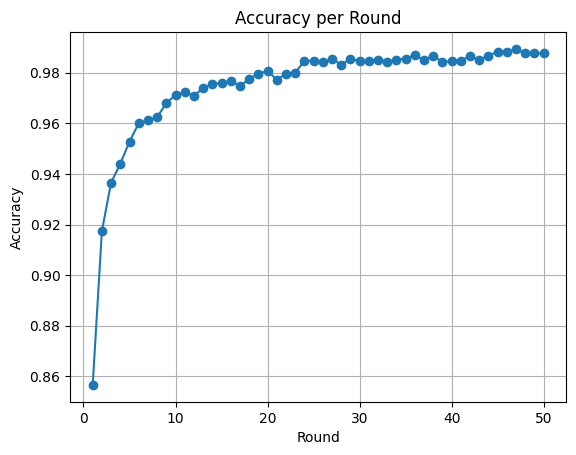

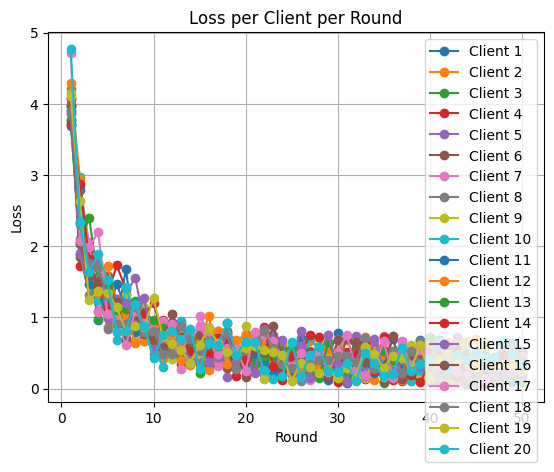

Classification Accuracy Matrix:
    Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1      0.868     0.840       NaN       NaN     0.836       NaN       NaN   
2      0.912       NaN     0.936       NaN       NaN       NaN     0.940   
3        NaN       NaN     0.952       NaN       NaN     0.944     0.932   
4      0.944     0.932       NaN     0.952     0.932       NaN       NaN   
5        NaN     0.940     0.968     0.956     0.940       NaN       NaN   
6      0.964     0.952     0.972       NaN       NaN     0.964     0.944   
7        NaN       NaN     0.980       NaN     0.948       NaN       NaN   
8        NaN     0.964       NaN     0.972     0.952       NaN       NaN   
9      0.976     0.968       NaN     0.972       NaN     0.960       NaN   
10       NaN     0.976     0.984     0.972       NaN     0.980       NaN   
11     0.972       NaN       NaN       NaN       NaN       NaN     0.968   
12     0.980     0.968       NaN     0.976       NaN    

In [ ]:
# Load model and data
NUM_CLIENTS = 40
ROUND = 50
p = 0.5

train_loaders, test_loaders, num_examples = load_data(NUM_CLIENTS)
strategy = CustomFedMedian(p, NUM_CLIENTS)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=ROUND),
    strategy=strategy
)

strategy.plot_accuracies()
strategy.plot_loss_per_client_per_round()
strategy.print_accuracy_matrix()

